In [1]:
%matplotlib notebook

import copy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from classes.Settings import Settings
from helpers.geometry_helpers import make_avg_fragment_if_not_exists
from helpers.helpers import read_results_alignment
from helpers.plot_functions import plot_density, plot_fragment_colored, plot_vdw_spheres
from helpers.density_helpers import calculate_no_bins, add_boundaries_per_bin

from sklearn.cluster import KMeans

from tqdm import tqdm
import time
import math
import copy

In [2]:
resolutions = []
resolutions0 = np.arange(0.02, 0.1, 0.01)
resolutions.extend(resolutions0)

resolutions1 = np.arange(0.1, 1.1, 0.1)
resolutions.extend(resolutions1)

## Volume central group

In [3]:
settings = Settings(".\\results\\H2O\\H2O_CF_vdw.5\\H2O_CF_vdw.5_aligned.csv")
settings.set_atom_to_count("F")

df = read_results_alignment(settings.get_aligned_csv_filename())
avg_fragment = make_avg_fragment_if_not_exists(settings, df)

print(avg_fragment)
vec1 = np.array([avg_fragment[avg_fragment.atom_label == "O2"].atom_x, avg_fragment[avg_fragment.atom_label == "O2"].atom_y, avg_fragment[avg_fragment.atom_label == "O2"].atom_z])
vec2 = np.array([avg_fragment[avg_fragment.atom_label == "H3"].atom_x, avg_fragment[avg_fragment.atom_label == "H3"].atom_y, avg_fragment[avg_fragment.atom_label == "H3"].atom_z])
vec2 = vec1 - vec2

dist1 = np.linalg.norm(vec1)
dist2 = np.linalg.norm(vec2)

angle = np.arccos(np.dot(vec1.T, vec2) / (dist1 * dist2))
print(dist1, dist2, np.rad2deg(angle[0])[0])

  atom_label atom_symbol    atom_x        atom_y        atom_z  vdw_radius
0         H1           H  0.000000  0.000000e+00  0.000000e+00        1.09
1         H3           H  1.131047  8.129646e-01 -5.680242e-17        1.09
2         O2           O  0.866111 -1.051792e-16 -2.394653e-17        1.52
0.8661108586162624 0.8550454989215917 108.0502384306134


In [4]:
def calc_distances(in_vdw_volume, bin_coordinates, avg_f_p, indices):

    for idx in indices:
        bin_point = bin_coordinates[idx[0]]
        distance = np.sum((bin_point - avg_f_p[:3])**2, axis=0)**0.5

        if distance < avg_f_p[3]:
            in_vdw_volume[idx] = 1

    return in_vdw_volume



def count_bins_in_vdw(avg_fragment, settings):
    avg_fragment['minx'] = avg_fragment['atom_x'] - avg_fragment['vdw_radius']
    avg_fragment['miny'] = avg_fragment['atom_y'] - avg_fragment['vdw_radius']
    avg_fragment['minz'] = avg_fragment['atom_z'] - avg_fragment['vdw_radius']
    avg_fragment['maxx'] = avg_fragment['atom_x'] + avg_fragment['vdw_radius']
    avg_fragment['maxy'] = avg_fragment['atom_y'] + avg_fragment['vdw_radius']
    avg_fragment['maxz'] = avg_fragment['atom_z'] + avg_fragment['vdw_radius']
    
    minx, miny, minz = avg_fragment['minx'].min(), avg_fragment['miny'].min(), avg_fragment['minz'].min()
    maxx, maxy, maxz = avg_fragment['maxx'].max(), avg_fragment['maxy'].max(), avg_fragment['maxz'].max()
    
    no_bins_x, minx, maxx = calculate_no_bins(minx, maxx, settings.resolution)
    no_bins_y, miny, maxy = calculate_no_bins(miny, maxy, settings.resolution)
    no_bins_z, minz, maxz = calculate_no_bins(minz, maxz, settings.resolution)
        
    amount_bins = no_bins_x * no_bins_y * no_bins_z
    indices = [i for i in range(0, amount_bins)]

    bins = [np.linspace(minx, maxx, num=no_bins_x, endpoint=False),
            np.linspace(miny, maxy, num=no_bins_y, endpoint=False),
            np.linspace(minz, maxz, num=no_bins_z, endpoint=False)] 

    df = add_boundaries_per_bin(bins, indices, settings)
    
    df['x_center'] = df.xstart + 0.5 * settings.resolution
    df['y_center'] = df.ystart + 0.5 * settings.resolution
    df['z_center'] = df.zstart + 0.5 * settings.resolution
    
    part_density = df[(df.x_center < maxx) & (df.x_center > minx) &
                      (df.y_center < maxy) & (df.y_center > miny) &
                      (df.z_center < maxz) & (df.z_center > minz)] 
    
    bin_coordinates = np.transpose(np.array([part_density.x_center, part_density.y_center, part_density.z_center]))

    time.sleep(0.5)
    
    in_vdw_vol = np.zeros(len(df))
    
    for i, atom in avg_fragment.iterrows():
        indices = np.transpose(np.where(in_vdw_vol == 0))
        
        fragment_point = np.array([atom.atom_x, atom.atom_y, atom.atom_z, atom.vdw_radius])

        in_vdw_vol = calc_distances(in_vdw_vol, bin_coordinates, fragment_point, indices)
                
    total = np.sum(in_vdw_vol)
    df['in_vdw_volume'] = in_vdw_vol
    
    print('Bins:', total)
    print('Volume:', total * settings.resolution**3)

    return df, total
    

In [5]:
settings = Settings(".\\results\\H2O\\H2O_CF_vdw.5\\H2O_CF_vdw.5_aligned.csv")
settings.set_atom_to_count("F")
settings.set_resolution(0.1)

df = read_results_alignment(settings.get_aligned_csv_filename())
avg_fragment = make_avg_fragment_if_not_exists(settings, df)

print(avg_fragment)

volume_df, amount_bins = count_bins_in_vdw(avg_fragment, settings)

print('Bins:', amount_bins)
print('Volume:', amount_bins * settings.resolution**3)

  atom_label atom_symbol    atom_x        atom_y        atom_z  vdw_radius
0         H1           H  0.000000  0.000000e+00  0.000000e+00        1.09
1         H3           H  1.131047  8.129646e-01 -5.680242e-17        1.09
2         O2           O  0.866111 -1.051792e-16 -2.394653e-17        1.52
Bins: 18475.0
Volume: 18.475000000000005
Bins: 18475.0
Volume: 18.475000000000005


In [6]:
display(volume_df)

plot_bins = volume_df[volume_df.in_vdw_volume > 0]


fig = plt.figure()
ax: Axes3D = fig.add_subplot(111, projection='3d')
plt.subplots_adjust(left=0.25, bottom=0.25)

ax.margins(x=0)
ax = plot_fragment_colored(ax, avg_fragment)

# Create vdw spheres around central group atoms
ax, spheres1 = plot_vdw_spheres(avg_fragment, ax, 'red')

ax.scatter(plot_bins.x_center, plot_bins.y_center, plot_bins.z_center, s=0.2)

ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")

,xstart,ystart,zstart,F,x_center,y_center,z_center,in_vdw_volume
0,-1.100000,-1.500000,-1.500000,0.0,-1.050000,-1.450000,-1.450000,0.0
1,-1.100000,-1.500000,-1.403226,0.0,-1.050000,-1.450000,-1.353226,0.0
2,-1.100000,-1.500000,-1.306452,0.0,-1.050000,-1.450000,-1.256452,0.0
3,-1.100000,-1.500000,-1.209677,0.0,-1.050000,-1.450000,-1.159677,0.0
4,-1.100000,-1.500000,-1.112903,0.0,-1.050000,-1.450000,-1.062903,0.0
...,...,...,...,...,...,...,...,...
39055,2.302778,1.802857,1.016129,0.0,2.352778,1.852857,1.066129,0.0
39056,2.302778,1.802857,1.112903,0.0,2.352778,1.852857,1.162903,0.0
39057,2.302778,1.802857,1.209677,0.0,2.352778,1.852857,1.259677,0.0
39058,2.302778,1.802857,1.306452,0.0,2.352778,1.852857,1.356452,0.0


<IPython.core.display.Javascript object>

Text(0.5, 0, 'Z axis')

In [7]:
settings = Settings(".\\results\\H2O\\H2O_CF_vdw.5\\H2O_CF_vdw.5_aligned.csv")
settings.set_atom_to_count("F")

H2O_bins = []
H2O_comp_time = []

for resolution in resolutions:
    print(round(resolution,2))
    
    starttime = time.time()
    settings.set_resolution(round(resolution,2))
    _, total = count_bins_in_vdw(avg_fragment, settings)
    H2O_bins.append(total)
    
    H2O_comp_time.append(time.time() - starttime)

0.02
Bins: 2144646.0
Volume: 17.157168000000002
0.03
Bins: 641222.0
Volume: 17.312993999999996
0.04
Bins: 272884.0
Volume: 17.464576000000005
0.05
Bins: 141038.0
Volume: 17.629750000000005
0.06
Bins: 82336.0
Volume: 17.784575999999998
0.07
Bins: 52262.0
Volume: 17.925866000000006
0.08
Bins: 35400.0
Volume: 18.124800000000004
0.09
Bins: 25061.0
Volume: 18.269468999999997
0.1
Bins: 18475.0
Volume: 18.475000000000005
0.2
Bins: 2505.0
Volume: 20.040000000000006
0.3
Bins: 818.0
Volume: 22.086
0.4
Bins: 371.0
Volume: 23.744000000000007
0.5
Bins: 204.0
Volume: 25.5
0.6
Bins: 125.0
Volume: 26.999999999999996
0.7
Bins: 86.0
Volume: 29.497999999999994
0.8
Bins: 66.0
Volume: 33.79200000000001
0.9
Bins: 42.0
Volume: 30.618000000000002
1.0
Bins: 35.0
Volume: 35.0


In [10]:
settings = Settings(".\\results\\NO3\\NO3_CF_vdw.5\\NO3_CF_vdw.5_aligned.csv")
settings.set_atom_to_count("F")

df = read_results_alignment(settings.get_aligned_csv_filename())
avg_fragment = make_avg_fragment_if_not_exists(settings, df)

NO3_bins = []
NO3_comp_time = []

for resolution in resolutions:
    print(round(resolution,2))
    starttime = time.time()
    
    settings.set_resolution(round(resolution,2))
    _, total = count_bins_in_vdw(avg_fragment, settings)
    NO3_bins.append(total)
    
    NO3_comp_time.append(time.time() - starttime)


0.02
Bins: 5083368.0
Volume: 40.66694400000001
0.03
Bins: 1516688.0
Volume: 40.95057599999999
0.04
Bins: 644601.0
Volume: 41.254464000000006
0.05
Bins: 332435.0
Volume: 41.55437500000001
0.06
Bins: 193834.0
Volume: 41.868143999999994
0.07
Bins: 122932.0
Volume: 42.16567600000001
0.08
Bins: 83019.0
Volume: 42.505728000000005
0.09
Bins: 58656.0
Volume: 42.760223999999994
0.1
Bins: 43018.0
Volume: 43.01800000000001
0.2
Bins: 5720.0
Volume: 45.76000000000001
0.3
Bins: 1840.0
Volume: 49.67999999999999
0.4
Bins: 826.0
Volume: 52.86400000000001
0.5
Bins: 456.0
Volume: 57.0
0.6
Bins: 256.0
Volume: 55.29599999999999
0.7
Bins: 190.0
Volume: 65.16999999999999
0.8
Bins: 138.0
Volume: 70.65600000000002
0.9
Bins: 88.0
Volume: 64.15200000000002
1.0
Bins: 67.0
Volume: 67.0


In [73]:
settings = Settings(".\\results\\RC6H5\\RC6H5_CF_vdw.5\RC6H5_CF_vdw.5_aligned.csv")
settings.set_atom_to_count("F")

df = read_results_alignment(settings.get_aligned_csv_filename())
avg_fragment = make_avg_fragment_if_not_exists(settings, df)

RC6H5_bins = []
RC6H5_comp_time = []

for resolution in resolutions:
    print(round(resolution,2))
    starttime = time.time()
    settings.set_resolution(round(resolution,2))
    _, total = count_bins_in_vdw(avg_fragment, settings)
    RC6H5_bins.append(total)
    
    RC6H5_comp_time.append(time.time() - starttime)

0.02
Bins: 11263220.0
Volume: 90.10576000000002
0.03
Bins: 3356058.0
Volume: 90.61356599999999
0.04
Bins: 1423673.0
Volume: 91.11507200000001
0.05
Bins: 733314.0
Volume: 91.66425000000002
0.06
Bins: 426523.0
Volume: 92.12896799999999
0.07
Bins: 270099.0
Volume: 92.64395700000003
0.08
Bins: 182049.0
Volume: 93.20908800000002
0.09
Bins: 128614.0
Volume: 93.75960599999999
0.1
Bins: 94325.0
Volume: 94.32500000000002
0.2
Bins: 12351.0
Volume: 98.80800000000002
0.3
Bins: 3865.0
Volume: 104.35499999999999
0.4
Bins: 1757.0
Volume: 112.44800000000002
0.5
Bins: 933.0
Volume: 116.625
0.6
Bins: 563.0
Volume: 121.60799999999999
0.7
Bins: 372.0
Volume: 127.59599999999998
0.8
Bins: 275.0
Volume: 140.80000000000004
0.9
Bins: 203.0
Volume: 147.98700000000002
1.0
Bins: 140.0
Volume: 140.0


In [74]:
settings = Settings(".\\results\\RC6F5\\RC6F5_CF_vdw.5\RC6F5_CF_vdw.5_aligned.csv")
settings.set_atom_to_count("F")

df = read_results_alignment(settings.get_aligned_csv_filename())
avg_fragment = make_avg_fragment_if_not_exists(settings, df)

RC6F5_bins = []
RC6F5_comp_time = []

for resolution in resolutions:
    print(round(resolution,2))
    starttime = time.time()
    settings.set_resolution(round(resolution,2))
    _, total = count_bins_in_vdw(avg_fragment, settings)
    RC6F5_bins.append(total)
    
    RC6F5_comp_time.append(time.time() - starttime)

0.02
Bins: 15442531.0
Volume: 123.54024800000002
0.03
Bins: 4599232.0
Volume: 124.17926399999997
0.04
Bins: 1949790.0
Volume: 124.78656000000002
0.05
Bins: 1003409.0
Volume: 125.42612500000003
0.06
Bins: 583529.0
Volume: 126.04226399999997
0.07
Bins: 369633.0
Volume: 126.78411900000003
0.08
Bins: 248911.0
Volume: 127.44243200000003
0.09
Bins: 175688.0
Volume: 128.076552
0.1
Bins: 128716.0
Volume: 128.71600000000004
0.2
Bins: 16887.0
Volume: 135.09600000000003
0.3
Bins: 5267.0
Volume: 142.20899999999997
0.4
Bins: 2300.0
Volume: 147.20000000000005
0.5
Bins: 1228.0
Volume: 153.5
0.6
Bins: 763.0
Volume: 164.80799999999996
0.7
Bins: 496.0
Volume: 170.12799999999996
0.8
Bins: 359.0
Volume: 183.80800000000005
0.9
Bins: 267.0
Volume: 194.64300000000003
1.0
Bins: 195.0
Volume: 195.0


[3069.7900285720825, 699.2143664360046, 333.2391653060913, 161.58068704605103, 102.50305223464966, 60.5739803314209, 40.739471435546875, 28.986721515655518, 21.605067253112793, 2.9041671752929688, 1.3357219696044922, 0.9200735092163086, 0.754920482635498, 0.6482508182525635, 0.6323778629302979, 0.5799553394317627, 0.5929009914398193, 0.5662298202514648]


<IPython.core.display.Javascript object>


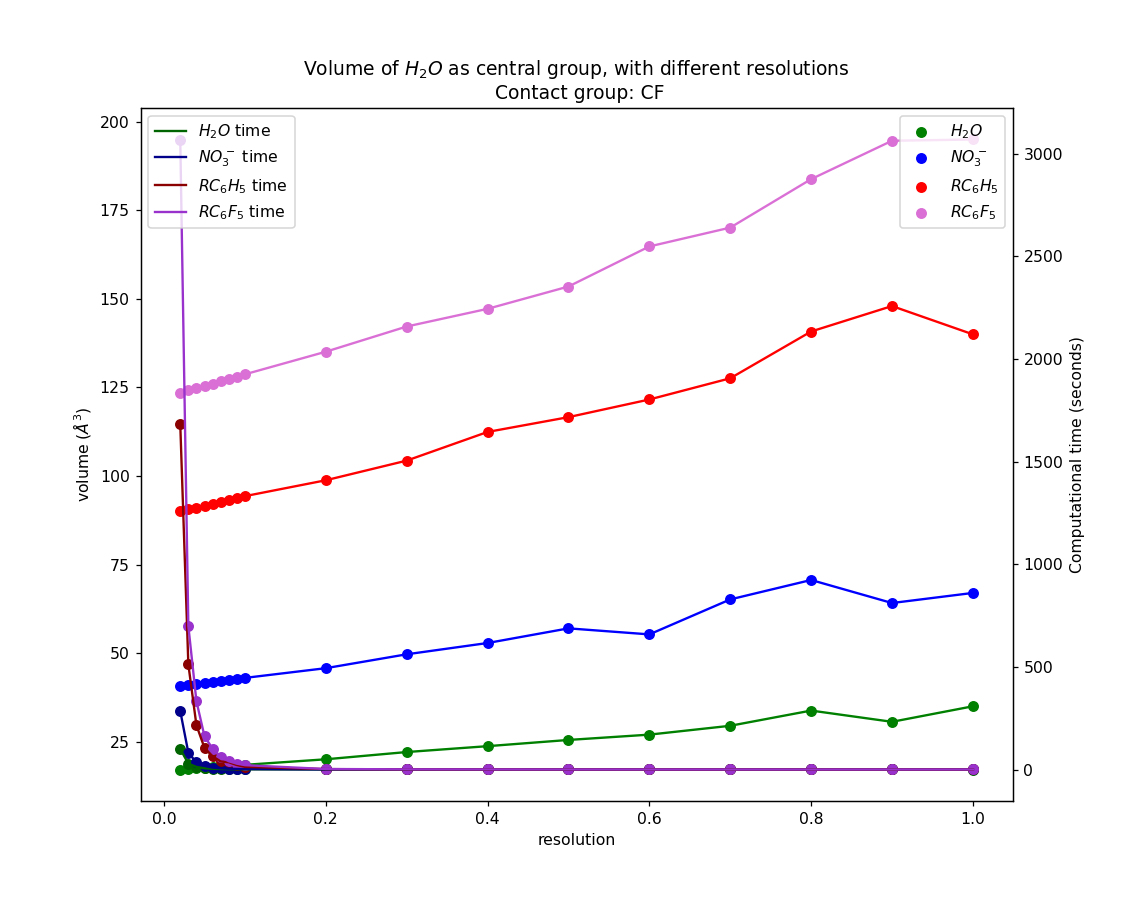

In [78]:
H2O_volumes = [H2O_bins[i] * round(resolutions[i], 2)**3 for i in range(len(H2O_bins))]
NO3_volumes = [NO3_bins[i] * round(resolutions[i], 2)**3 for i in range(len(NO3_bins))]
RC6H5_volumes = [RC6H5_bins[i] * round(resolutions[i], 2)**3 for i in range(len(RC6H5_bins))]
RC6F5_volumes = [RC6F5_bins[i] * round(resolutions[i], 2)**3 for i in range(len(RC6F5_bins))]

print(RC6F5_comp_time)

fig, ax = plt.subplots(figsize=(10,8))
plt.title("Volume of $H_2O$ as central group, with different resolutions\n Contact group: CF")

ax.scatter(resolutions, H2O_volumes, label="$H_2O$", color='green')
ax.plot(resolutions, H2O_volumes, color='green')
ax.scatter(resolutions, NO3_volumes, label="$NO_3^-$", color='blue')
ax.plot(resolutions, NO3_volumes, color='blue')
ax.scatter(resolutions, RC6H5_volumes, label="$RC_6H_5$", color='red')
ax.plot(resolutions, RC6H5_volumes, color='red')
ax.scatter(resolutions, RC6F5_volumes, label="$RC_6F_5$", color='orchid')
ax.plot(resolutions, RC6F5_volumes, color='orchid')

ax2 = ax.twinx()
# ax2.set_yscale('log')
ax2.plot(resolutions, H2O_comp_time, color='darkgreen', label="$H_2O$ time")
ax2.scatter(resolutions, H2O_comp_time, color='darkgreen')
ax2.plot(resolutions, NO3_comp_time, color='darkblue', label='$NO_3^-$ time')
ax2.scatter(resolutions, NO3_comp_time, color='darkblue')

ax2.scatter(resolutions, RC6H5_comp_time, color='darkred')
ax2.plot(resolutions, RC6H5_comp_time, color='darkred', label="$RC_6H_5$ time")

ax2.scatter(resolutions, RC6F5_comp_time, color='darkorchid')
ax2.plot(resolutions, RC6F5_comp_time, color='darkorchid', label="$RC_6F_5$ time")


ax2.set_ylabel('Computational time (seconds)')
ax.set_ylabel(r'volume ($\AA^3$)')
ax.set_xlabel("resolution")
ax.legend(loc='upper right')
ax2.legend(loc='upper left')

plt.show()

In [85]:
import csv

with open("test.csv", "a", newline='') as resultsFile:
    writer = csv.writer(resultsFile, delimiter=",")
    
    for i in range(len(resolutions)):
        print(round(resolutions[i], 2), H2O_bins[i], NO3_bins[i], RC6H5_bins[i], RC6F5_bins[i])
    
        writer.writerow([round(resolutions[i], 2), H2O_bins[i], H2O_comp_time[i], NO3_bins[i], NO3_comp_time[i], 
                         RC6H5_bins[i], RC6H5_comp_time[i], RC6F5_bins[i], RC6F5_comp_time[i]])

0.02 2144646.0 5083368.0 11263220.0 15442531.0
0.03 641222.0 1516688.0 3356058.0 4599232.0
0.04 272884.0 644601.0 1423673.0 1949790.0
0.05 141038.0 332435.0 733314.0 1003409.0
0.06 82336.0 193834.0 426523.0 583529.0
0.07 52262.0 122932.0 270099.0 369633.0
0.08 35400.0 83019.0 182049.0 248911.0
0.09 25061.0 58656.0 128614.0 175688.0
0.1 18475.0 43018.0 94325.0 128716.0
0.2 2505.0 5720.0 12351.0 16887.0
0.3 818.0 1840.0 3865.0 5267.0
0.4 371.0 826.0 1757.0 2300.0
0.5 204.0 456.0 933.0 1228.0
0.6 125.0 256.0 563.0 763.0
0.7 86.0 190.0 372.0 496.0
0.8 66.0 138.0 275.0 359.0
0.9 42.0 88.0 203.0 267.0
1.0 35.0 67.0 140.0 195.0
